## Installing the packages

In [42]:
!pip install google-play-scraper
!pip install pandas
# !pip install numpy
!pip install nltk
!pip install Sastrawi
!pip install matplotlib
!pip install wordcloud


[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


## Scraping the data from Google Play RCTI+ Superapp reviews

In [43]:
import ssl
import pandas as pd
# import numpy as np
from google_play_scraper import Sort, reviews

ssl._create_default_https_context = ssl._create_unverified_context

rplus_reviews, continuation_token = reviews(
    'com.fta.rctitv',
    sort=Sort.MOST_RELEVANT,
    count=1000
)

df = pd.DataFrame(rplus_reviews)
df.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount',
    'reviewCreatedVersion', 'replyContent', 'repliedAt', 'at'], axis=1, inplace=True)
df.head()

,content,score
0,14-second ad for broadcasts that run ads longe...,2
1,It's a great application for an alternative to...,5
2,"Good apps. It's very easy to use, imteresting ...",5
3,Its actually pretty good even the ui/ux is not...,5
4,"Good apps, very easy to use, i can watch my fa...",5


## Preprocessing the reviews

In [44]:
import nltk
import re
from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

nltk.download('stopwords')

# create stemmer english language
stemmer_eng = nltk.SnowballStemmer('english')

# create stemmer indonesian language
factory = StemmerFactory()
stemmer_ina = factory.create_stemmer()


stopword_eng = set(stopwords.words('english'))
stopword_ina = set(stopwords.words('indonesian'))

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"                 # dingbats char
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def clean(text):
    text = str(text).lower()                                           # transform text to lowercase
    text = re.sub(r'\[.*?\]', '', text)                                # remove '[]' and words in it
    text = re.sub(r'https?://\S+|www\.\S+', '', text)                  # remove links
    text = re.sub(r'<.*?>+', '', text)                                 # remove '<>' and words in it
    text = re.sub(f'[%s]' % re.escape(string.punctuation), '', text)   # remove punctuation
    text = re.sub(r'\n', '', text)                                     # remove line feeds
    text = remove_emojis(text)                                         # remove emojis
    text = re.sub(r'\w*\d\w*', '', text)                               # remove numbers and words
    text = [word for word in text.split(' ')
        if word not in stopword_eng and word not in stopword_ina]      # remove stopwords
    text = [stemmer_eng.stem(word) for word in text]                   # stem the english text
    text = [stemmer_ina.stem(word) for word in text]                   # stem the indonesian text
    text = " ".join(text)
    return text

df['content_clean'] = df['content'].apply(clean)
df['content_clean']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/riobatubara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       ad broadcast run ad longer  minut that much m...
1      great applic altern watch show rcti program tr...
2      good app easi use imterest make easier watch t...
3      actual pretti good even uiux easi use watch ma...
4      good app easi use watch favorit movi everytim ...
                             ...                        
995                                         well bad app
996                                             like app
997                                       goodd app favv
998                               jd bleng lode lamakkkk
999                                            good like
Name: content_clean, Length: 1000, dtype: object

## Creating sentiment score

In [45]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sentiments = SentimentIntensityAnalyzer()

df['positive'] = [sentiments.polarity_scores(i)['pos'] for i in df['content_clean']]
df['negative'] = [sentiments.polarity_scores(i)['neg'] for i in df['content_clean']]
df['neutral'] = [sentiments.polarity_scores(i)['neu'] for i in df['content_clean']]
df['compound'] = [sentiments.polarity_scores(i)['compound'] for i in df['content_clean']]

df = df[['content', 'content_clean', 'score', 'positive', 'negative', 'neutral', 'compound']]
df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/riobatubara/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,content,content_clean,score,positive,negative,neutral,compound
0,14-second ad for broadcasts that run ads longe...,ad broadcast run ad longer minut that much m...,2,0.000,0.088,0.912,-0.4939
1,It's a great application for an alternative to...,great applic altern watch show rcti program tr...,5,0.299,0.000,0.701,0.6751
2,"Good apps. It's very easy to use, imteresting ...",good app easi use imterest make easier watch t...,5,0.388,0.000,0.612,0.6908
3,Its actually pretty good even the ui/ux is not...,actual pretti good even uiux easi use watch ma...,5,0.209,0.000,0.791,0.4404
4,"Good apps, very easy to use, i can watch my fa...",good app easi use watch favorit movi everytim ...,5,0.310,0.000,0.690,0.6597
...,...,...,...,...,...,...,...
995,Well. Bad apps,well bad app,1,0.318,0.530,0.152,-0.3400
996,I like this app,like app,5,0.714,0.000,0.286,0.3612
997,"goodd app, favv",goodd app favv,5,0.000,0.000,1.000,0.0000
998,jd bleng loding lamakkkk,jd bleng lode lamakkkk,1,0.000,0.000,1.000,0.0000


In [46]:
result = df["compound"].values
sentiment = []

for i in result:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')

df["sentiment"] = sentiment
df.head()

,content,content_clean,score,positive,negative,neutral,compound,sentiment
0,14-second ad for broadcasts that run ads longe...,ad broadcast run ad longer minut that much m...,2,0.000,0.088,0.912,-0.4939,Negative
1,It's a great application for an alternative to...,great applic altern watch show rcti program tr...,5,0.299,0.000,0.701,0.6751,Positive
2,"Good apps. It's very easy to use, imteresting ...",good app easi use imterest make easier watch t...,5,0.388,0.000,0.612,0.6908,Positive
3,Its actually pretty good even the ui/ux is not...,actual pretti good even uiux easi use watch ma...,5,0.209,0.000,0.791,0.4404,Positive
4,"Good apps, very easy to use, i can watch my fa...",good app easi use watch favorit movi everytim ...,5,0.310,0.000,0.690,0.6597,Positive


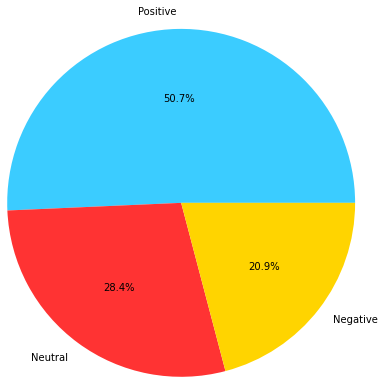

In [47]:
import matplotlib.pyplot as plt

scores = df['sentiment'].value_counts()

plt.pie(df['sentiment'].value_counts(),
        labels=scores.index,
        autopct='%1.1f%%',
        radius=2,
        colors=['#3bccff','#ff3333', '#ffd400'])
plt.show()

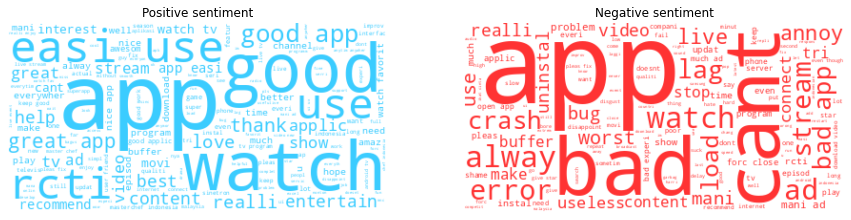

In [48]:
from wordcloud import WordCloud, STOPWORDS
import random

# separate dataframe into sentiments for separated analysis
df_positive = df.loc[df['sentiment'] == 'Positive']
df_negative = df.loc[df['sentiment'] == 'Negative']
TXT_POSITIVE = ' '.join(i for i in df_positive['content_clean'])
TXT_NEGATIVE = ' '.join(i for i in df_negative['content_clean'])

def color_func_positive(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    color = '#3bccff' + str(random.randrange(50, 100, 10))
    return color

def color_func_negative(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    color = '#ff3333' + str(random.randrange(50, 100, 10))
    return color

wc_stopwords = set(STOPWORDS)

wordcloud_positive = WordCloud(stopwords=wc_stopwords,
    background_color="white",
    colormap="inferno",
    color_func=color_func_positive).generate(TXT_POSITIVE)

wordcloud_negative = WordCloud(stopwords=wc_stopwords,
    background_color="white",
    colormap="inferno",
    color_func=color_func_negative).generate(TXT_NEGATIVE)

figure, axis = plt.subplots(1,2, figsize=(15, 15))
axis[0].imshow(wordcloud_positive, interpolation='bilinear')
axis[0].set_title('Positive sentiment')
axis[0].axis('off')
axis[1].imshow(wordcloud_negative, interpolation='bilinear')
axis[1].set_title('Negative sentiment')
axis[1].axis('off')

plt.show()